In [1]:
import sys
sys.path.append('../')
import torch
import itertools
from probe.load_data import WordInspectionDataset, SentenceParaphraseInspectionDataset
from scipy.spatial.distance import cosine
from statistics import mean 
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
import argparse
import time
import random

/anaconda3/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)
DEBUG:matplotlib:CACHEDIR=/Users/paigefink/.matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from /Users/paigefink/.matplotlib/fontlist-v300.json
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
words, paraphrase_sent_pairs = 'words', 'para_pairs'

def main(input_args):
    if input_args.comparison_type == words:
        word_usage_comparisons(input_args)
    else:
        sentence_paraphrase_comparisons(input_args)


def sentence_paraphrase_comparisons(input_args):
    dataset = SentenceParaphraseInspectionDataset(input_args.input, input_args.embedding_model, 
                                                input_args.embedding_batch_size, input_args.run_name)

    embeddings = get_embeddings(dataset, input_args.embedding_cache, flattened=True)
    embedding_outputs, encoded_inputs, indices, _pools = embeddings
    sentence_embeddings = get_sentence_embeddings(embeddings, dataset)

    paraphrase_cosine_metrics = calculate_sentence_paraphrase_cosine_metrics(dataset, embedding_outputs, 
                                                                            encoded_inputs, sentence_embeddings)
    
    print(paraphrase_cosine_metrics)
    print(summarize_sentence_similarity_comp(paraphrase_cosine_metrics))


def word_usage_comparisons(input_args):
    dataset = WordInspectionDataset(input_args.input, input_args.embedding_model, 
                                    input_args.embedding_batch_size, input_args.run_name)
    embeddings = get_embeddings(dataset, input_args.embedding_cache, flattened=False)
    embedding_outputs, encoded_inputs, _indices, _pools = embeddings
    data = dataset.get_data()
    idiom_sentence_indexes = get_idiom_sentences(data)
    print(idiom_sentence_indexes)

    word_sim_results = calculate_word_cosine_metrics(dataset, embedding_outputs, encoded_inputs, idiom_sentence_indexes)
#     print(word_sim_results)
    print(summarize_word_similarity_comp(word_sim_results))

    PCA_comparisions(dataset, embedding_outputs, encoded_inputs, idiom_sentence_indexes)


def get_embeddings(data, embedding_cache, flattened):
    if embedding_cache is None:
        if flattened:
            encoded_data = data.get_flattened_encoded()
        else:
            encoded_data = data.get_encoded()
        return data.bert_word_embeddings(encoded_data)
    return data.load_saved_embeddings(embedding_cache)

def get_sentence_embeddings(embeddings, data):
    embedding_outputs, encoded_inputs, indices, _pools = embeddings
    return data.aggregate_sentence_embeddings(embedding_outputs, encoded_inputs, indices)

def calculate_sentence_paraphrase_cosine_metrics(dataset, embedding_outputs, encoded_inputs, sentence_embeddings):
    data = dataset.get_data()
    paraphrase_cosine_metrics = [calculate_paraphrase_pair_similarity(i, pair_sents, dataset, encoded_inputs, sentence_embeddings) 
                            for i, pair_sents in enumerate(data)]
    return paraphrase_cosine_metrics

def calculate_word_cosine_metrics(dataset, embedding_outputs, encoded_inputs, idiom_sentence_indexes):
    word_cosine_metrics = [calculate_word_similarity_metrics(idiom_sent_idx_group, dataset, embedding_outputs, 
                                                             encoded_inputs) 
                            for idiom_sent_idx_group in idiom_sentence_indexes]
    return word_cosine_metrics

def calculate_paraphrase_pair_similarity(index, classifier_out, dataset, encoded_inputs, sentence_embeddings):
    cosine_sim = 1 - cosine(sentence_embeddings[index][0], sentence_embeddings[index][1])
    
    return {
        'pair_index': index,
        'sent_1': dataset.decode(encoded_inputs[index][0].tolist()),
        'sent_2': dataset.decode(encoded_inputs[index][1].tolist()),
        'paraphrase': classifier_out.label,
        'judgment': classifier_out.classifier_judgment,
        'cosine_similarity': cosine_sim
    }    

def calculate_word_similarity_metrics(idiom_sent_index_group, dataset, embedding_outputs, encoded_inputs, random_indexes=None):
    data = dataset.get_data()
    idiom_exs = [data[idiom_sent_index] for idiom_sent_index in idiom_sent_index_group]
    idiom_word_embeddings = [get_word_embedding(dataset, data, embedding_outputs, 
                                               encoded_inputs, idiom_sent_index) 
                            for idiom_sent_index in idiom_sent_index_group]
    cosine_similarity_metrics = {}
    
    pair_id = idiom_exs[0].pair_id
    idiom_word = idiom_exs[0].word

    literal_usage_sents = [i for i, ex in enumerate(data) if ex.pair_id == pair_id and 
                                                            ex.word == idiom_word and not 
                                                            ex.figurative ]
    paraphrase_sents = [i for i, ex in enumerate(data) if ex.pair_id == pair_id 
                                                            and not ex.word == idiom_word]

    literal_usage_embeddings = [get_word_embedding(dataset, data, embedding_outputs, encoded_inputs, lit_idx) 
                                for lit_idx in literal_usage_sents]
    paraphrase_embeddings = [get_word_embedding(dataset, data, embedding_outputs, encoded_inputs, para_idx) 
                             for para_idx in paraphrase_sents]
    

    cosine_similarity_metrics['fig_to_literal'] = calculate_cosine_similarity_average(idiom_word_embeddings, 
                                                                                      literal_usage_embeddings)
    cosine_similarity_metrics['literal_to_literal'] = calculate_cosine_similarity_average(literal_usage_embeddings)
    cosine_similarity_metrics['fig_to_paraphrase'] = calculate_cosine_similarity_average(idiom_word_embeddings, 
                                                                                         paraphrase_embeddings)
    cosine_similarity_metrics['literal_to_paraphrase'] = calculate_cosine_similarity_average(literal_usage_embeddings,
                                                                                             paraphrase_embeddings)
    
    if random_indexes:
        random_embeddings = [get_word_embedding(dataset, data, embedding_outputs, encoded_inputs, random_idx) 
                             for random_idx in random_indexes]
        cosine_similarity_metrics['fig_to_random'] = calculate_cosine_similarity_average(idiom_word_embeddings,
                                                                                         random_embeddings)

    
    return {
        'pair_id': pair_id,
        'sentences': [dataset.decode(encoded_inputs[idiom_sent_index].tolist()) for idiom_sent_index in idiom_sent_index_group],
        'word': idiom_word,
        'paraphrase_word': data[paraphrase_sents[0]].word,
        'cosine_similarities': cosine_similarity_metrics,
    }

def get_idiom_sentences(dataset):
    idioms = [(i, ex) for i, ex in enumerate(dataset) if ex.figurative]
    values = set(map(lambda x:x[1].pair_id, idioms))
    return [[y[0] for y in idioms if y[1].pair_id == x] for x in values]

def get_sentences_for_idiom_sentence(dataset, idiom_sent):
    literal_usage_sents = [i for i, ex in enumerate(dataset) if ex.pair_id == idiom_sent.pair_id and 
                                                                ex.word == idiom_sent.word and not 
                                                                ex.sentence_id == idiom_sent.sentence_id ]
    paraphrase_sents = [i for i, ex in enumerate(dataset) if ex.pair_id == idiom_sent.pair_id and not 
                                                            ex.word == idiom_sent.word]
    return (literal_usage_sents, paraphrase_sents)

def get_word_embedding(dataset, data, embedding_outputs, encoded_inputs, dataset_index):
    ex = data[dataset_index]
    decoded_tokens = dataset.get_decoded_tokens(encoded_inputs[dataset_index].tolist())
#     print()
#     print()
#     print(ex.sentence)
#     print(decoded_tokens)
#     print()
    word_index = decoded_tokens.index(ex.word[0])
    return embedding_outputs[dataset_index][word_index]

def calculate_cosine_similarity_average(embeddings_1, embeddings_2=None):
    if embeddings_2:
        embedding_pairs = list(itertools.product(embeddings_1, embeddings_2))
    else:
        embedding_pairs = list(itertools.combinations(embeddings_1, 2))

    cosine_similarities = [1 - cosine(embedding_1, embedding_2) for embedding_1, embedding_2 in embedding_pairs]
    
    if not cosine_similarities:
        return 'N/A'
    return mean(cosine_similarities)

# This computes the average difference in cosine similarity between:
# 1.) literal to literal usages versus figurative to literal usage
# 2.) figurative to paraphrase usages versus literal to paraphrase useage
def summarize_word_similarity_comp(results):
    literal_sim_advantage = [result['cosine_similarities']['literal_to_literal'] - result['cosine_similarities']['fig_to_literal'] for result in results]
    fig_to_paraphrase_advantage = [result['cosine_similarities']['fig_to_paraphrase'] - result['cosine_similarities']['literal_to_paraphrase'] for result in results]
    
    summary_stats = {
        'lit_to_lit_improvement_over_fig_to_lit': mean(literal_sim_advantage),
        'fig_to_paraphrase_improvement_over_lit_to_paraphrase': mean(fig_to_paraphrase_advantage)
    }
    return summary_stats

# This computes the average cosine similarity scores between paraphrase pairs,
# grouped into 4 categories based on gold label (i.e. true paraphrase or not) and classifier judgment
def summarize_sentence_similarity_comp(results):
    correctly_judged_paraphrases = [result['cosine_similarity'] for result in results if result['paraphrase'] and result['judgment']]
    correctly_judged_non_paraphrases = [result['cosine_similarity'] for result in results if not result['paraphrase'] and not result['judgment']]
    incorrectly_judged_paraphrases =  [result['cosine_similarity'] for result in results if result['paraphrase'] and not result['judgment']]
    incorrectly_judged_non_paraphrases =  [result['cosine_similarity'] for result in results if not result['paraphrase'] and result['judgment']]

    return {
        'average_cosine_sim_for_correctly_judged_paraphrases': handle_zero_case(correctly_judged_paraphrases),
        'average_cosine_sim_for_correctly_judged_non_paraphrases': handle_zero_case(correctly_judged_non_paraphrases),
        'average_cosine_sim_for_incorrectly_judged_paraphrases': handle_zero_case(incorrectly_judged_paraphrases),
        'average_cosine_sim_for_incorrectly_judged_non_paraphrases': handle_zero_case(incorrectly_judged_non_paraphrases)
    }

def handle_zero_case(category_results):
    if not category_results:
        return 'N/A'
    return mean(category_results)


# PCA visualization code
# TODO: figure out what we actually want to include/disclude here and clean up

def PCA_comparisions(dataset, embedding_outputs, encoded_inputs, idiom_sentence_indexes):
    data = dataset.get_data()
    for num, idiom_sent_index_group in enumerate(idiom_sentence_indexes):
        idiom_exs = [data[idiom_sent_index] for idiom_sent_index in idiom_sent_index_group]
        
        idiom_word_embeddings = [get_word_embedding(dataset, data, embedding_outputs, 
                                               encoded_inputs, idiom_sent_index) 
                            for idiom_sent_index in idiom_sent_index_group]
        pair_id = idiom_exs[0].pair_id
        idiom_word = idiom_exs[0].word[0]
        literal_usage_sents = [i for i, ex in enumerate(data) if ex.pair_id == pair_id and 
                                                                ex.word[0] == idiom_word and not 
                                                                ex.figurative ]
        paraphrase_sents = [i for i, ex in enumerate(data) if ex.pair_id == pair_id 
                                                                and not ex.word[0] == idiom_word]

        literal_usage_embeddings = [get_word_embedding(dataset, data, embedding_outputs, encoded_inputs, lit_idx) 
                                    for lit_idx in literal_usage_sents]
        
     
        paraphrase_embeddings = [get_word_embedding(dataset, data, embedding_outputs, encoded_inputs, para_idx) 
                                 for para_idx in paraphrase_sents]

        import logging
        logger = logging.getLogger()
        logger.setLevel(logging.CRITICAL)
        
        print("\n\n\n\n\n")
        print("Example " + str(num))
        print("Figurative phrases:  ")
        for idiom_ex in idiom_exs:
            print(" ".join(idiom_ex.sentence))
        print()
        print("Idiom usage word:  " + idiom_word)
        print("Paraphrase word:  " + data[paraphrase_sents[0]].word[0])
        
        title = 'PCA for: "{}"'.format(idiom_word)
        targets = {
            'labels': ['figurative', 'literal'],
            'values': [0, 1] ,
            'colors': ['turquoise', 'navy'],
        }
        labels =  np.array(len(literal_usage_embeddings) * [1] + len(idiom_word_embeddings) * [0])
        
        
        show_PCS(literal_usage_embeddings + idiom_word_embeddings, labels, targets, title)

        title = 'PCA for: "{}"; Paraphrase word: {}'.format(idiom_word[0], data[paraphrase_sents[0]].word)
        targets = {
            'labels': ['figurative', 'literal', 'paraphrase'],
            'values': [0, 1, 2] ,
            'colors': ['turquoise', 'navy', 'orangered'],
        }
        embeddings = literal_usage_embeddings + idiom_word_embeddings + paraphrase_embeddings
        labels =  np.array(len(literal_usage_embeddings) * [1] + len(idiom_word_embeddings) * [0] + len(paraphrase_embeddings) * [2])
        show_PCS(embeddings, labels, targets, title)
        
        random_id = random.choice([999, 899, 799])
        random_word_sents = [i for i, ex in enumerate(data) if ex.pair_id == random_id]
        random_word_embeddings = [get_word_embedding(dataset, data, embedding_outputs, encoded_inputs, rnd_idx) 
                                  for rnd_idx in random_word_sents]
  
        title = 'PCA for: "{}"; Paraphrase word: {}; Random word: {}'.format(idiom_word[0], 
                                                                        data[paraphrase_sents[0]].word,
                                                                        data[random_word_sents[0]].word)
        targets = {
            'labels': ['figurative', 'literal', 'paraphrase', 'random'],
            'values': [0, 1, 2, 3] ,
            'colors': ['turquoise', 'navy', 'orangered', 'gray'],
        }
        
        embeddings = literal_usage_embeddings + idiom_word_embeddings + paraphrase_embeddings + random_word_embeddings
        labels =  np.array(len(literal_usage_embeddings) * [1] + len(idiom_word_embeddings) * [0] + len(paraphrase_embeddings) * [2] + len(random_word_embeddings) * [3])
        
        show_PCS(embeddings, labels, targets, title)
        
        word_cosine_results = calculate_word_similarity_metrics(idiom_sent_index_group, dataset,
                                                                embedding_outputs, 
                                                                encoded_inputs, random_word_sents)['cosine_similarities'] 
        
        print("Cosine similarity scores")
        for pair_type, cosine_val in word_cosine_results.items():
            print(pair_type, ": " + str(cosine_val))

def show_PCS(embeddings, labels, targets, title):
    pca = PCA(2)  
    projected = pca.fit_transform(torch.stack(embeddings))

    for color, i, target_name in zip(targets['colors'], targets['values'], targets['labels']):
        plt.scatter(projected[labels == i, 0], projected[labels == i, 1], color=color,  lw=2,
                    label=target_name)
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.title(title)
    plt.show()


In [4]:
class objectview(object):
    def __init__(self, d):
        self.__dict__ = d

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): s3.amazonaws.com:443
DEBUG:urllib3.connectionpool:https://s3.amazonaws.com:443 "HEAD /models.huggingface.co/bert/bert-large-uncased-vocab.txt HTTP/1.1" 200 0
INFO:transformers.tokenization_utils:loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-vocab.txt from cache at /Users/paigefink/.cache/torch/transformers/9b3c03a36e83b13d5ba95ac965c9f9074a99e14340c523ab405703179e79fc46.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
INFO:data_loading:Loading 'bert-large-uncased' model
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): s3.amazonaws.com:443
DEBUG:urllib3.connectionpool:https://s3.amazonaws.com:443 "HEAD /models.huggingface.co/bert/bert-large-uncased-config.json HTTP/1.1" 200 0
INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-config.json from cache at /Users/paigefink/.cac

INFO:data_loading:processed 16/318 sentences, batch max sentence length 32, total max sentence length 32
INFO:data_loading:processed 32/318 sentences, batch max sentence length 34, total max sentence length 34
INFO:data_loading:processed 48/318 sentences, batch max sentence length 33, total max sentence length 34
INFO:data_loading:processed 64/318 sentences, batch max sentence length 37, total max sentence length 37
INFO:data_loading:processed 80/318 sentences, batch max sentence length 37, total max sentence length 37
INFO:data_loading:processed 96/318 sentences, batch max sentence length 31, total max sentence length 37
INFO:data_loading:processed 112/318 sentences, batch max sentence length 28, total max sentence length 37
INFO:data_loading:processed 128/318 sentences, batch max sentence length 33, total max sentence length 37
INFO:data_loading:processed 144/318 sentences, batch max sentence length 39, total max sentence length 39
INFO:data_loading:processed 160/318 sentences, batch

INFO:data_loading:Caching inputs.pt in cache/word_large_test
INFO:data_loading:Caching indices.pt in cache/word_large_test
INFO:data_loading:Caching pools.pt in cache/word_large_test


[[24, 25, 26, 27, 28], [72, 73, 74, 75, 76], [168, 169, 170, 171, 172], [96, 97, 98, 99, 100], [48, 49, 50, 51, 52], [144, 145, 146, 147, 148], [216, 217, 218, 219, 220], [120, 121, 122, 123, 124], [264, 265, 266, 267, 268], [192, 193, 194, 195, 196], [240, 241, 242, 243, 244], [0, 1, 2, 3, 4]]
{'lit_to_lit_improvement_over_fig_to_lit': 0.14948607029206068, 'fig_to_paraphrase_improvement_over_lit_to_paraphrase': 0.03380815212774758}






Example 0
Figurative phrases:  
soon we ' re going to hit the sack .
so if you ' re exercising close to bed ##time , calm down by med ##itating or doing a few gentle yoga poses before you hit the sack .
would it be okay with you if we had a bite to eat now and hit the sack early ?
i think i ' m gonna hit the sack before i get even more uncomfortable .
but before you hit the sack , follow this expert advice for solving morning beauty emergencies .

Idiom usage word:  sack
Paraphrase word:  bed


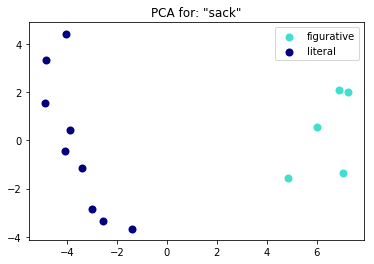

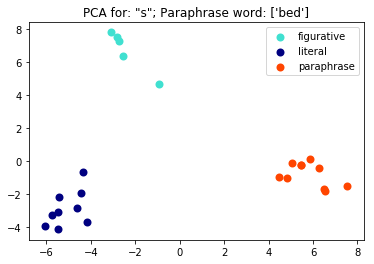

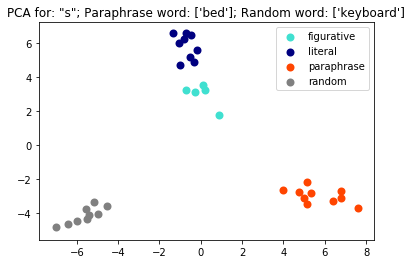

Cosine similarity scores
fig_to_literal : 0.5078671601083543
literal_to_literal : 0.7760081407096651
fig_to_paraphrase : 0.4553066474199295
literal_to_paraphrase : 0.4630802750587463
fig_to_random : 0.3933758662806617






Example 1
Figurative phrases:  
it ' s not always easy making decisions on the fly as a d ##m but here ' s what he probably should have done so that it wasn ' t obvious .
that ' s a fairly advanced feature for any presentation device and requires a lot of computing power to do on the fly .
but i certainly won ' t let them know i ' m t ##we ##aking things on the fly .
operating on the fly , obama made a tough call and it seems like it was a good one .
often these changes happened on the fly , daily , in response to sudden customer demand or customer loss .

Idiom usage word:  fly
Paraphrase word:  spontaneously


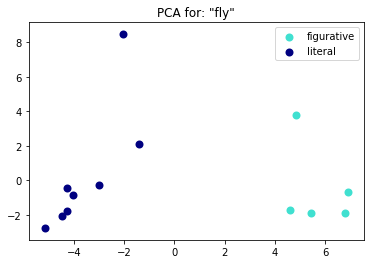

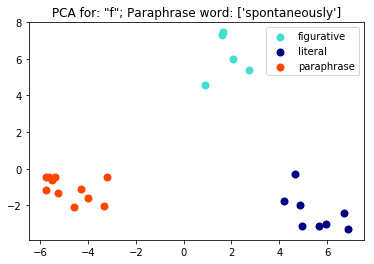

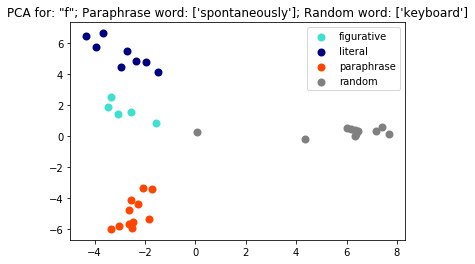

Cosine similarity scores
fig_to_literal : 0.5233455263078213
literal_to_literal : 0.6911123735564095
fig_to_paraphrase : 0.48859338760375975
literal_to_paraphrase : 0.405544332482598
fig_to_random : 0.4474125374447216






Example 2
Figurative phrases:  
razor is aiming for that same market corner and they have set the bar rather high for it based on speculation .
but apple has set the bar for magical technology and the iphone 5 failed to impress .
take care not to set the bar too low - - - - low goals will not mo ##tiv ##ate you .
it ' s worth noting for rams fans , though , that they set the bar insane ##ly high by hitting on so many rookie ##s .
after it was released in 1998 , grim fan ##dan ##go blew everyone away and set the bar ridiculous ##ly high for adventure games .

Idiom usage word:  bar
Paraphrase word:  standard


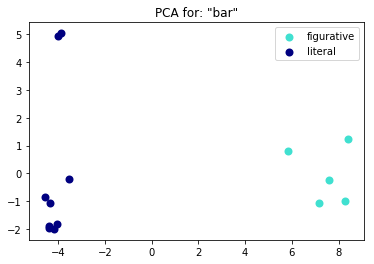

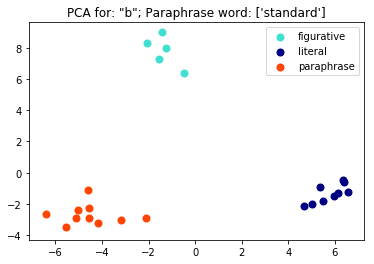

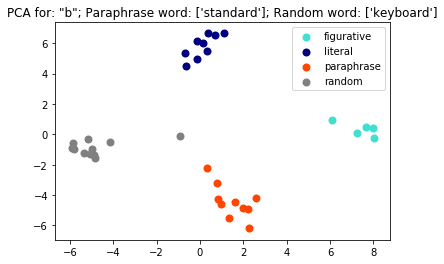

Cosine similarity scores
fig_to_literal : 0.5169897397359212
literal_to_literal : 0.8094712545474371
fig_to_paraphrase : 0.48567103981971743
literal_to_paraphrase : 0.4168248640166389
fig_to_random : 0.4187466350468722






Example 3
Figurative phrases:  
i dunn ##o , what ' s the opportunity cost in the long run ?
that marriage must be good for children is an argument that , by itself , can not pre ##va ##il in the attempt to preserve marriage in the long run .
i would suggest buying your milk at grocery stores , in the long run you ' ll save money versus making multiple trips .
in the long run , people buy from artists they trust .
some organizations thrive for only a few quarters , but in the long run , they may be extremely unstable .

Idiom usage word:  run
Paraphrase word:  future


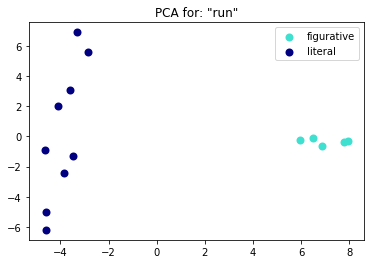

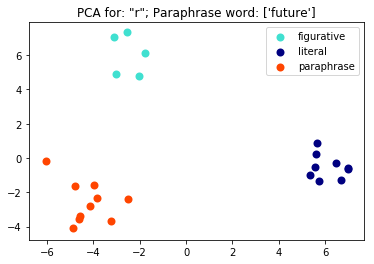

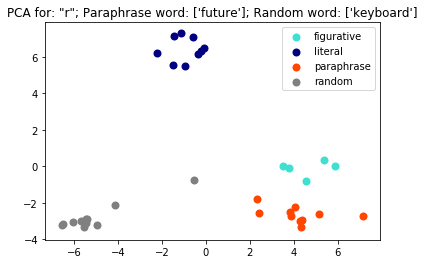

Cosine similarity scores
fig_to_literal : 0.49534959064589607
literal_to_literal : 0.7137141070432134
fig_to_paraphrase : 0.5862216317653656
literal_to_paraphrase : 0.42573184967041017
fig_to_random : 0.4492705442688682






Example 4
Figurative phrases:  
you ' re just going to have to bite the bullet and get through it .
one possible response to this second example is to bite the bullet and to argue that from the point of view of fundamental physics , there really is no difference .
like everything else in life , you ' re kind of just forced to bite the bullet and see the bigger picture .
at that point you should bite the bullet and spend $ 2 , 199 on a 15 - inch re ##tina mac ##book pro that offers the same storage space .
that ' s why it ' s time to bite the bullet , suck it up and look to the future .

Idiom usage word:  bullet
Paraphrase word:  situation


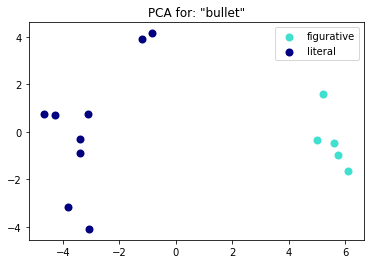

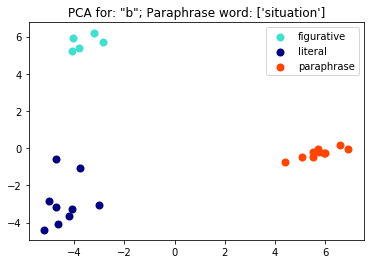

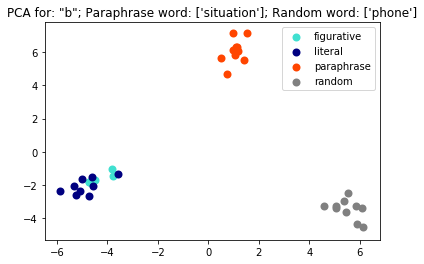

Cosine similarity scores
fig_to_literal : 0.6549312326643202
literal_to_literal : 0.815031561586592
fig_to_paraphrase : 0.47785315692424774
literal_to_paraphrase : 0.4762022074725893
fig_to_random : 0.47555739402770997






Example 5
Figurative phrases:  
i think i ' m going to hold on to it and maybe i ' ll find something to do with it later down the road .
the goal may be a long way down the road , but the humanity ' s total command over nature should be ultimate aim .
we support terrorist elements , most recently in syria and libya , but before that in iraq , bosnia , kosovo , and afghanistan , and then find ourselves fighting them down the road .
who ' s going to pay for all of that free stuff down the road ?
this problem has been kicked down the road long enough .

Idiom usage word:  road
Paraphrase word:  future


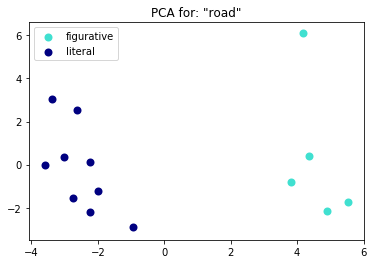

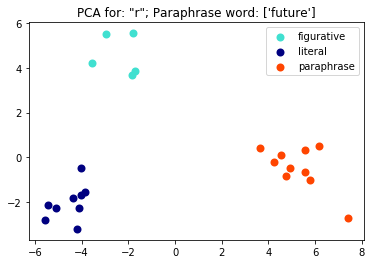

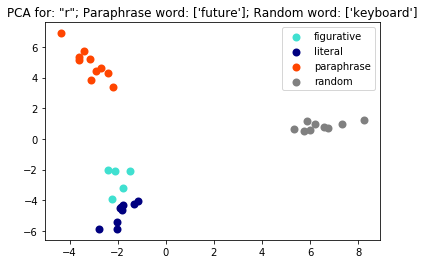

Cosine similarity scores
fig_to_literal : 0.6193201886283026
literal_to_literal : 0.7589576062228944
fig_to_paraphrase : 0.48924335837364197
literal_to_paraphrase : 0.4648018353515201
fig_to_random : 0.45737734701898364






Example 6
Figurative phrases:  
i think he has bigger fish to fry .
jazz has bigger fish to fry than worrying whether her breasts are as big as her contemporaries .
don ' t you have bigger fish to fry ?
although this is an important subject , there are bigger fish to fry .
americans are going to have far bigger fish to fry at home soon enough .

Idiom usage word:  fish
Paraphrase word:  problems


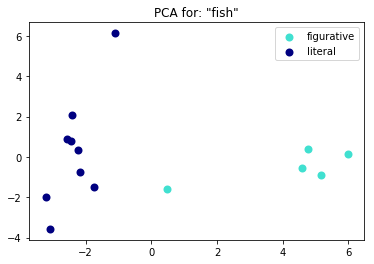

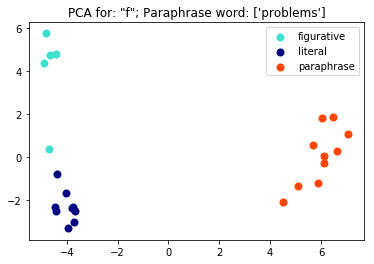

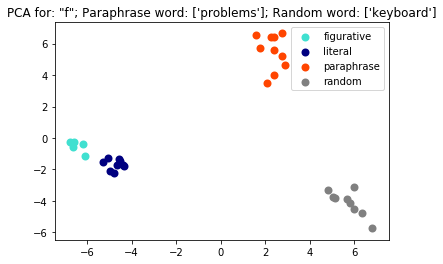

Cosine similarity scores
fig_to_literal : 0.7634283317459954
literal_to_literal : 0.8070428503884209
fig_to_paraphrase : 0.47748918294906617
literal_to_paraphrase : 0.4461246331532796
fig_to_random : 0.3881032466888428






Example 7
Figurative phrases:  
lafayette , on the other hand , is one of the more culturally diverse cities i know .
every minute of down ##time for a large site , on the other hand , could mean hundreds if not thousands of dollars in lost revenue .
on the other hand , it is kind of distracting .
samsung ' s hardware pioneering , on the other hand , needs more work .
my husband , on the other hand , goes several times a week and doesn ' t like to miss it .

Idiom usage word:  hand
Paraphrase word:  perspective


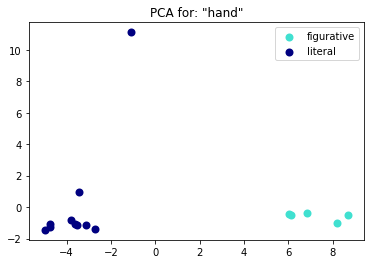

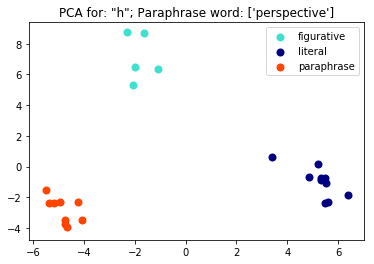

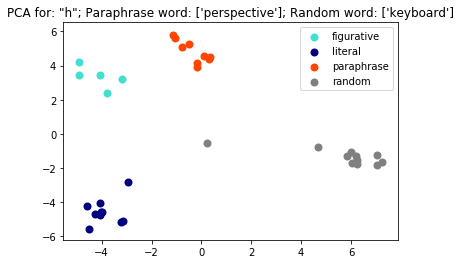

Cosine similarity scores
fig_to_literal : 0.49345803081989287
literal_to_literal : 0.6568815045886569
fig_to_paraphrase : 0.5552750666936238
literal_to_paraphrase : 0.4280410637458166
fig_to_random : 0.43559492392973465






Example 8
Figurative phrases:  
isn ' t the elephant in the room how the f he ' s typing without arms ?
in the interview , cr ##ump described race as being the elephant in the room when it comes to the tray ##von case .
there is a bit of an elephant in the room at the moment about the lack of openly the ##ist posters .
let me first address the elephant in the room .
this is the elephant in the room we ' ve all been waiting for , " burr ##is said .

Idiom usage word:  elephant
Paraphrase word:  unspoken


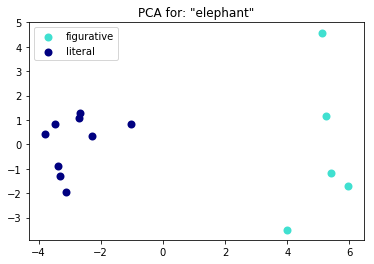

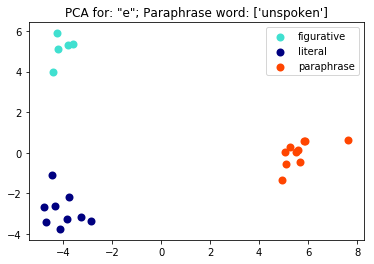

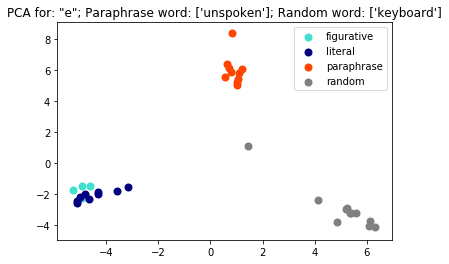

Cosine similarity scores
fig_to_literal : 0.6677969363000658
literal_to_literal : 0.8225974159108268
fig_to_paraphrase : 0.4524363243579865
literal_to_paraphrase : 0.43814966446823544
fig_to_random : 0.44877760952169243






Example 9
Figurative phrases:  
i feel like we ' re on the same page ; tho you ' re much further along in bad ##ass status .
although anthony is doing all he can to improve his game , he must also make sure he is on the same page with his teammates .
we can all try to get on the same page as far as what psalms , readings and collects to use .
or you could let him know that you see marriage in your future and only want to date men who are on the same page .
i think you and i are on the same page .

Idiom usage word:  page
Paraphrase word:  understanding


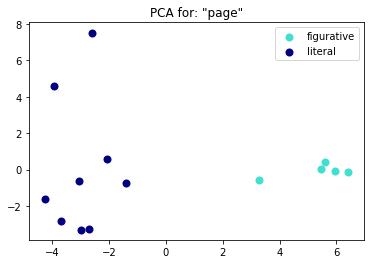

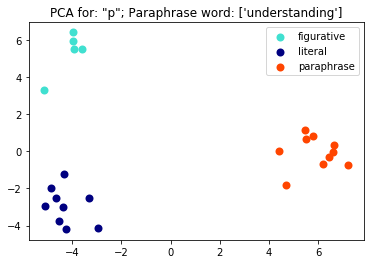

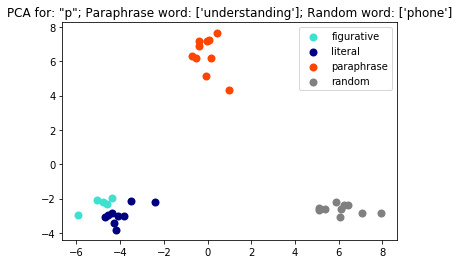

Cosine similarity scores
fig_to_literal : 0.6003379199239943
literal_to_literal : 0.6755004872878393
fig_to_paraphrase : 0.4341611623764038
literal_to_paraphrase : 0.40954631666342417
fig_to_random : 0.4244678348302841






Example 10
Figurative phrases:  
and if you ' ve resort ##ed to name - calling , maybe you should just call it a day , as you have obviously run out of actual * arguments * .
buy ' em off , and call it a day .
rather than just return it and call it a day , i restored the device from scratch .
i usually just call it a day , scout out the water or go for a hike .
after a couple of hours of enjoying the surfing , without another soul in sight since this spot hardly ever has good waves , i was about to call it a day and go back home .

Idiom usage word:  day
Paraphrase word:  finish


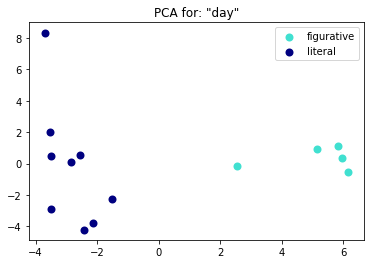

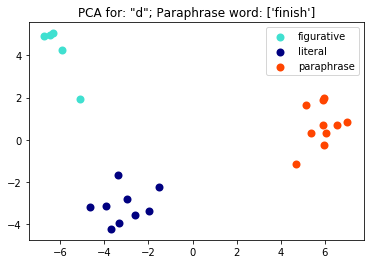

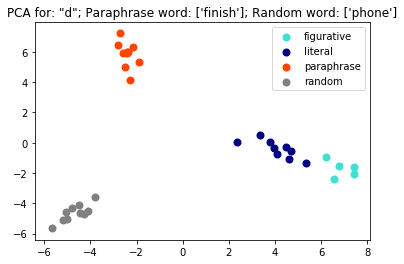

Cosine similarity scores
fig_to_literal : 0.608217865228653
literal_to_literal : 0.6560962514744865
fig_to_paraphrase : 0.3891855174303055
literal_to_paraphrase : 0.45900104410118525
fig_to_random : 0.4099407869577408






Example 11
Figurative phrases:  
why did you have to let the cat out of the bag like that ?
i don ' t want to let the cat out of the bag yet , " he said .
i ' m worried of not only causing discomfort for my dad , but also humiliation for my mom if annie decides to let the cat out of the bag .
she didn ' t mean to let the cat out of the bag .
the point was that once i let the cat out of the bag , the secret cease ##s to be a secret anymore and defeats more than one purpose .

Idiom usage word:  cat
Paraphrase word:  secret


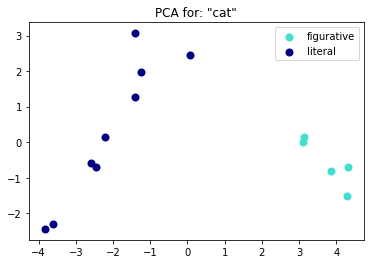

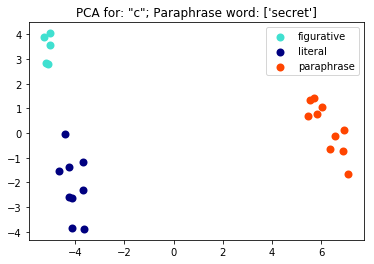

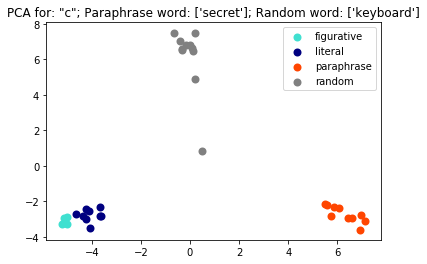

Cosine similarity scores
fig_to_literal : 0.8186240818765428
literal_to_literal : 0.881085894174046
fig_to_paraphrase : 0.484090301990509
literal_to_paraphrase : 0.5367808659871419
fig_to_random : 0.4626228977333416


In [5]:
# BERT - LARGE

word_args = {
   'comparison_type': 'words',
    'input': 'word_vec_sim_test.txt',
    'embedding_model': 'bert-large-uncased',
    'run_name': 'word_large_test',
    'embedding_batch_size': 16,
    'embedding_cache': None
#         'embedding_cache': 'cache/word_large_test'
}

main(objectview(word_args))


[[24, 25, 26, 27, 28], [72, 73, 74, 75, 76], [168, 169, 170, 171, 172], [96, 97, 98, 99, 100], [48, 49, 50, 51, 52], [144, 145, 146, 147, 148], [216, 217, 218, 219, 220], [120, 121, 122, 123, 124], [264, 265, 266, 267, 268], [192, 193, 194, 195, 196], [240, 241, 242, 243, 244], [0, 1, 2, 3, 4]]
{'lit_to_lit_improvement_over_fig_to_lit': 0.13888214154178818, 'fig_to_paraphrase_improvement_over_lit_to_paraphrase': 0.02358184770218242}






Example 0
Figurative phrases:  
soon we ' re going to hit the sack .
so if you ' re exercising close to bed ##time , calm down by med ##itating or doing a few gentle yoga poses before you hit the sack .
would it be okay with you if we had a bite to eat now and hit the sack early ?
i think i ' m gonna hit the sack before i get even more uncomfortable .
but before you hit the sack , follow this expert advice for solving morning beauty emergencies .

Idiom usage word:  sack
Paraphrase word:  bed


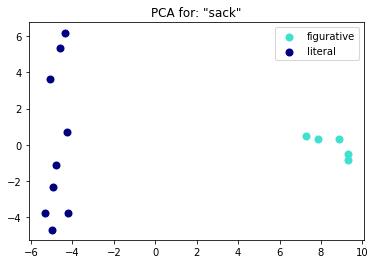

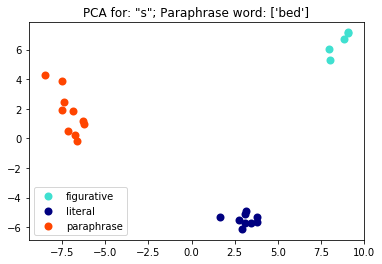

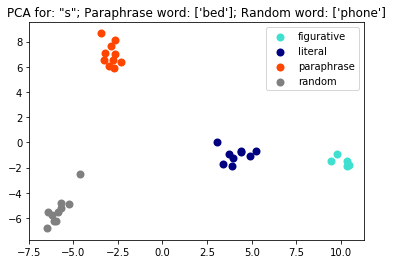

Cosine similarity scores
fig_to_literal : 0.4551829550001356
literal_to_literal : 0.6645340902937783
fig_to_paraphrase : 0.2761309492588043
literal_to_paraphrase : 0.33391864862706927
fig_to_random : 0.2359662428498268






Example 1
Figurative phrases:  
it ' s not always easy making decisions on the fly as a d ##m but here ' s what he probably should have done so that it wasn ' t obvious .
that ' s a fairly advanced feature for any presentation device and requires a lot of computing power to do on the fly .
but i certainly won ' t let them know i ' m t ##we ##aking things on the fly .
operating on the fly , obama made a tough call and it seems like it was a good one .
often these changes happened on the fly , daily , in response to sudden customer demand or customer loss .

Idiom usage word:  fly
Paraphrase word:  spontaneously


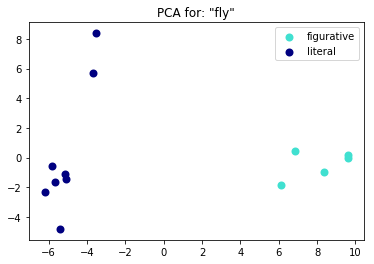

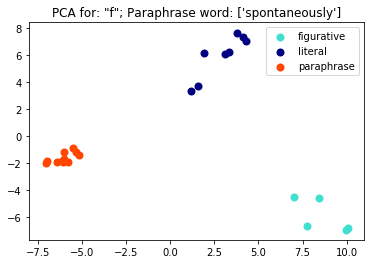

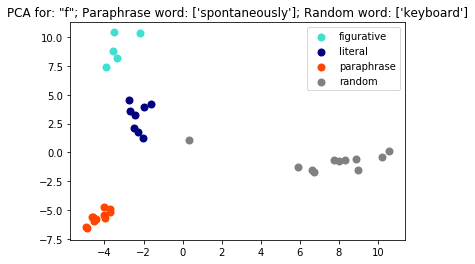

Cosine similarity scores
fig_to_literal : 0.3900121137499809
literal_to_literal : 0.6548756456800869
fig_to_paraphrase : 0.23094647472554988
literal_to_paraphrase : 0.2955976150591265
fig_to_random : 0.2597976177930832






Example 2
Figurative phrases:  
razor is aiming for that same market corner and they have set the bar rather high for it based on speculation .
but apple has set the bar for magical technology and the iphone 5 failed to impress .
take care not to set the bar too low - - - - low goals will not mo ##tiv ##ate you .
it ' s worth noting for rams fans , though , that they set the bar insane ##ly high by hitting on so many rookie ##s .
after it was released in 1998 , grim fan ##dan ##go blew everyone away and set the bar ridiculous ##ly high for adventure games .

Idiom usage word:  bar
Paraphrase word:  standard


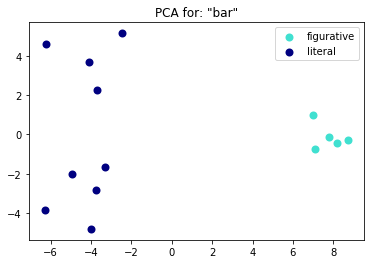

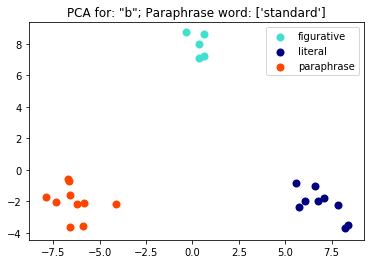

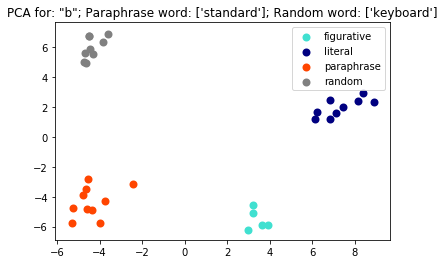

Cosine similarity scores
fig_to_literal : 0.4721359027756585
literal_to_literal : 0.7299918764167361
fig_to_paraphrase : 0.37161235213279725
literal_to_paraphrase : 0.2689890772104263
fig_to_random : 0.2700599322716395






Example 3
Figurative phrases:  
i dunn ##o , what ' s the opportunity cost in the long run ?
that marriage must be good for children is an argument that , by itself , can not pre ##va ##il in the attempt to preserve marriage in the long run .
i would suggest buying your milk at grocery stores , in the long run you ' ll save money versus making multiple trips .
in the long run , people buy from artists they trust .
some organizations thrive for only a few quarters , but in the long run , they may be extremely unstable .

Idiom usage word:  run
Paraphrase word:  future


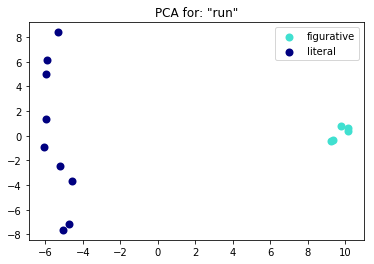

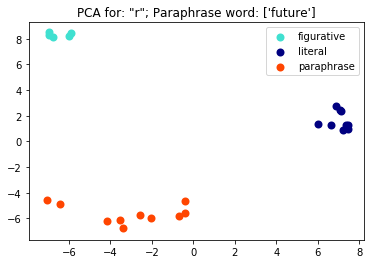

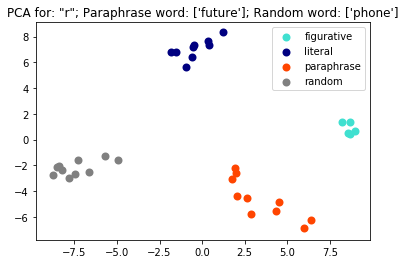

Cosine similarity scores
fig_to_literal : 0.3217652519543966
literal_to_literal : 0.5933951710661253
fig_to_paraphrase : 0.36568596750497817
literal_to_paraphrase : 0.2773039393954807
fig_to_random : 0.23313608676195144






Example 4
Figurative phrases:  
you ' re just going to have to bite the bullet and get through it .
one possible response to this second example is to bite the bullet and to argue that from the point of view of fundamental physics , there really is no difference .
like everything else in life , you ' re kind of just forced to bite the bullet and see the bigger picture .
at that point you should bite the bullet and spend $ 2 , 199 on a 15 - inch re ##tina mac ##book pro that offers the same storage space .
that ' s why it ' s time to bite the bullet , suck it up and look to the future .

Idiom usage word:  bullet
Paraphrase word:  situation


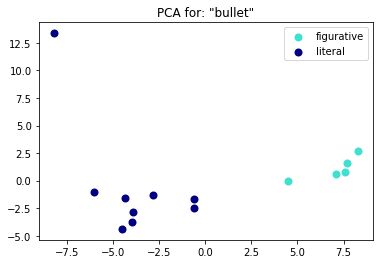

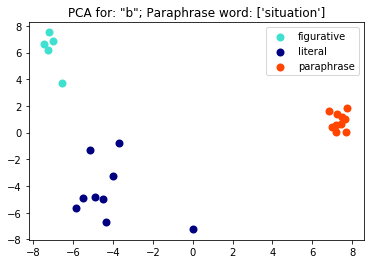

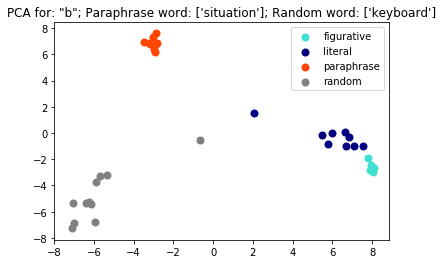

Cosine similarity scores
fig_to_literal : 0.5115336471133762
literal_to_literal : 0.6093573595086733
fig_to_paraphrase : 0.26123886078596115
literal_to_paraphrase : 0.2795856863247334
fig_to_random : 0.28674511150880294






Example 5
Figurative phrases:  
i think i ' m going to hold on to it and maybe i ' ll find something to do with it later down the road .
the goal may be a long way down the road , but the humanity ' s total command over nature should be ultimate aim .
we support terrorist elements , most recently in syria and libya , but before that in iraq , bosnia , kosovo , and afghanistan , and then find ourselves fighting them down the road .
who ' s going to pay for all of that free stuff down the road ?
this problem has been kicked down the road long enough .

Idiom usage word:  road
Paraphrase word:  future


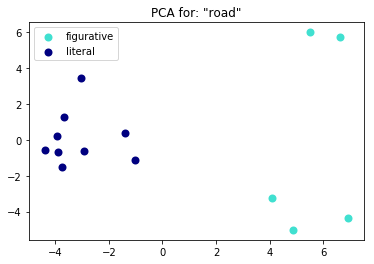

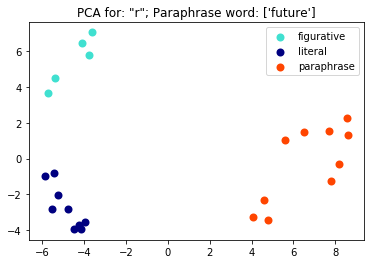

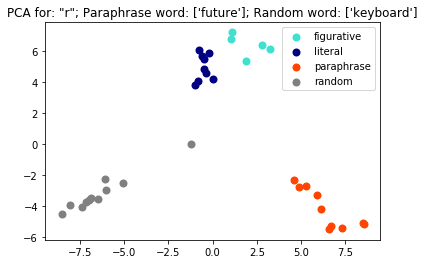

Cosine similarity scores
fig_to_literal : 0.5530774063534207
literal_to_literal : 0.6708070950375663
fig_to_paraphrase : 0.34469433665275573
literal_to_paraphrase : 0.32435108506017263
fig_to_random : 0.3170004356991161






Example 6
Figurative phrases:  
i think he has bigger fish to fry .
jazz has bigger fish to fry than worrying whether her breasts are as big as her contemporaries .
don ' t you have bigger fish to fry ?
although this is an important subject , there are bigger fish to fry .
americans are going to have far bigger fish to fry at home soon enough .

Idiom usage word:  fish
Paraphrase word:  problems


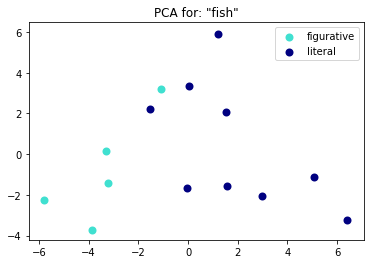

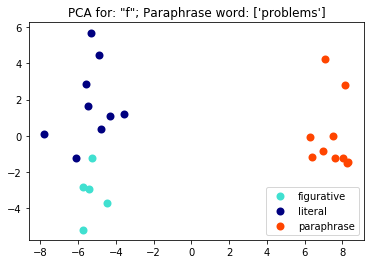

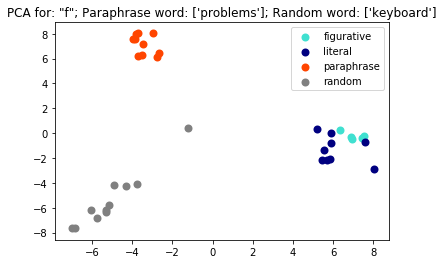

Cosine similarity scores
fig_to_literal : 0.7023938324716356
literal_to_literal : 0.7030541135205163
fig_to_paraphrase : 0.2881389430165291
literal_to_paraphrase : 0.2592485329343213
fig_to_random : 0.3009078486399217






Example 7
Figurative phrases:  
lafayette , on the other hand , is one of the more culturally diverse cities i know .
every minute of down ##time for a large site , on the other hand , could mean hundreds if not thousands of dollars in lost revenue .
on the other hand , it is kind of distracting .
samsung ' s hardware pioneering , on the other hand , needs more work .
my husband , on the other hand , goes several times a week and doesn ' t like to miss it .

Idiom usage word:  hand
Paraphrase word:  perspective


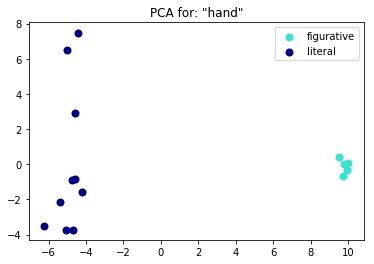

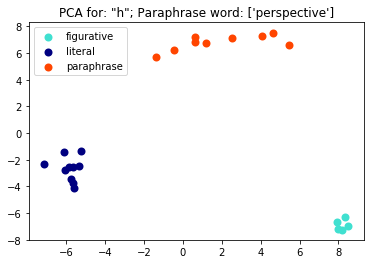

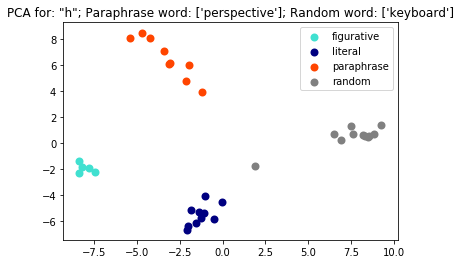

Cosine similarity scores
fig_to_literal : 0.3304079440236092
literal_to_literal : 0.5558276136716207
fig_to_paraphrase : 0.3537328730026881
literal_to_paraphrase : 0.2952085084385342
fig_to_random : 0.22557796023108742






Example 8
Figurative phrases:  
isn ' t the elephant in the room how the f he ' s typing without arms ?
in the interview , cr ##ump described race as being the elephant in the room when it comes to the tray ##von case .
there is a bit of an elephant in the room at the moment about the lack of openly the ##ist posters .
let me first address the elephant in the room .
this is the elephant in the room we ' ve all been waiting for , " burr ##is said .

Idiom usage word:  elephant
Paraphrase word:  unspoken


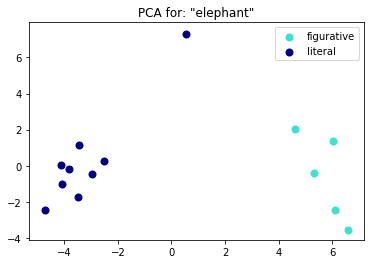

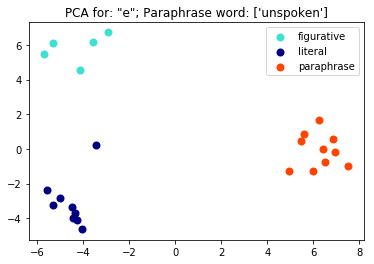

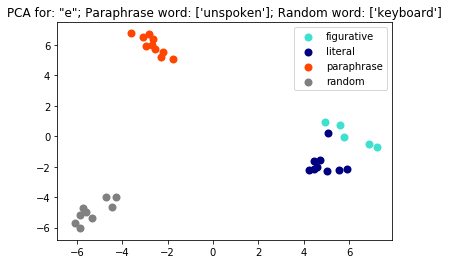

Cosine similarity scores
fig_to_literal : 0.5823585934109158
literal_to_literal : 0.7246185855733024
fig_to_paraphrase : 0.34672622799873354
literal_to_paraphrase : 0.31804326160086527
fig_to_random : 0.3396510230170356






Example 9
Figurative phrases:  
i feel like we ' re on the same page ; tho you ' re much further along in bad ##ass status .
although anthony is doing all he can to improve his game , he must also make sure he is on the same page with his teammates .
we can all try to get on the same page as far as what psalms , readings and collects to use .
or you could let him know that you see marriage in your future and only want to date men who are on the same page .
i think you and i are on the same page .

Idiom usage word:  page
Paraphrase word:  understanding


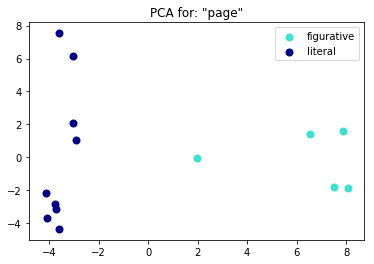

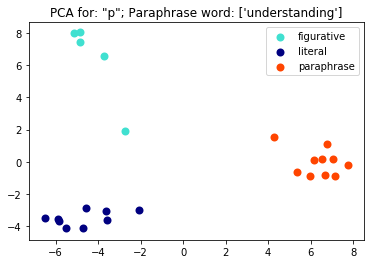

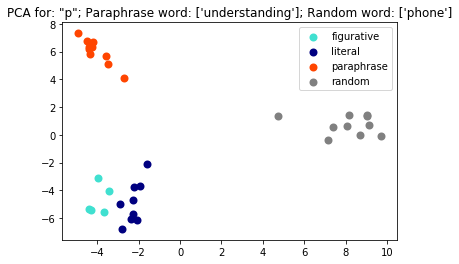

Cosine similarity scores
fig_to_literal : 0.4975332942273882
literal_to_literal : 0.5795615100198321
fig_to_paraphrase : 0.3886608242988586
literal_to_paraphrase : 0.3072500311666065
fig_to_random : 0.3058504483103752






Example 10
Figurative phrases:  
and if you ' ve resort ##ed to name - calling , maybe you should just call it a day , as you have obviously run out of actual * arguments * .
buy ' em off , and call it a day .
rather than just return it and call it a day , i restored the device from scratch .
i usually just call it a day , scout out the water or go for a hike .
after a couple of hours of enjoying the surfing , without another soul in sight since this spot hardly ever has good waves , i was about to call it a day and go back home .

Idiom usage word:  day
Paraphrase word:  finish


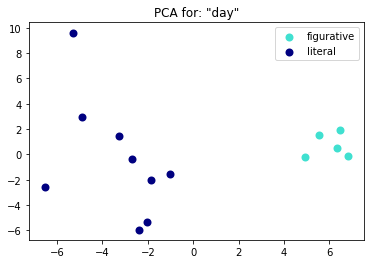

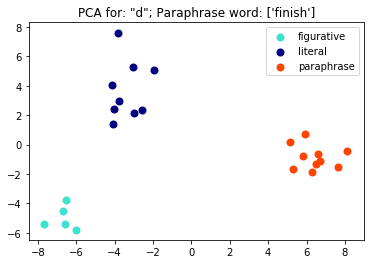

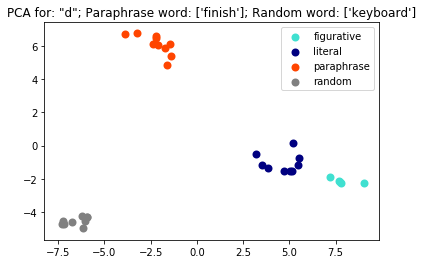

Cosine similarity scores
fig_to_literal : 0.5071577760908339
literal_to_literal : 0.4836655590269301
fig_to_paraphrase : 0.3030741161108017
literal_to_paraphrase : 0.2931324894229571
fig_to_random : 0.254891456829177






Example 11
Figurative phrases:  
why did you have to let the cat out of the bag like that ?
i don ' t want to let the cat out of the bag yet , " he said .
i ' m worried of not only causing discomfort for my dad , but also humiliation for my mom if annie decides to let the cat out of the bag .
she didn ' t mean to let the cat out of the bag .
the point was that once i let the cat out of the bag , the secret cease ##s to be a secret anymore and defeats more than one purpose .

Idiom usage word:  cat
Paraphrase word:  secret


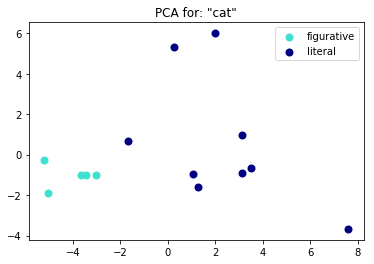

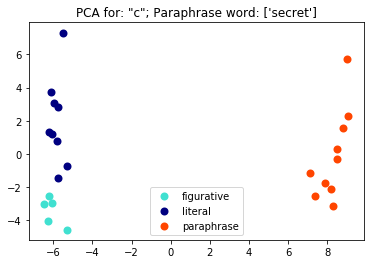

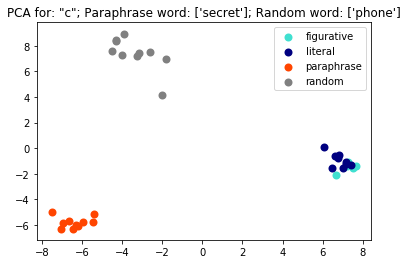

Cosine similarity scores
fig_to_literal : 0.7601594991154141
literal_to_literal : 0.7806152949730555
fig_to_paraphrase : 0.31236143708229064
literal_to_paraphrase : 0.30739231490426594
fig_to_random : 0.33368135035037993


In [6]:
# BERT- BASE 

word_args = {
   'comparison_type': 'words',
    'input': 'word_vec_sim_test.txt',
    'embedding_model': 'bert-base-uncased',
    'run_name': 'word_base_test',
    'embedding_batch_size': 16,
    'embedding_cache': None,
#     'embedding_cache': 'word_base_test'
}

main(objectview(word_args))

In [7]:
# BERT - LARGE

sent_args = {
   'comparison_type': 'para_pairs',
    'input': '../probe/output/daniel/train_classifications.tsv',
    'embedding_model': 'bert-large-uncased',
    'run_name': 'paraphrase_large_test',
    'embedding_batch_size': 16,
    'embedding_cache': 'paraphrase_large_test'
}

# main(objectview(sent_args))

In [8]:
sent_args = {
   'comparison_type': 'para_pairs',
    'input': '../probe/output/daniel/train_classifications.tsv',
    'embedding_model': 'bert-large-uncased',
    'run_name': 'paraphrase_large_test',
    'embedding_batch_size': 16,
    'embedding_cache': 'cache/paraphrase_large_test'
}

# main(objectview(sent_args))